In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/Users/fahimafridi/downloads/spam.csv')

In [3]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.shape

(5572, 2)

In [5]:
data.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [7]:
data['length'] = data['Message'].apply(len)

In [8]:
data.head()

,Category,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

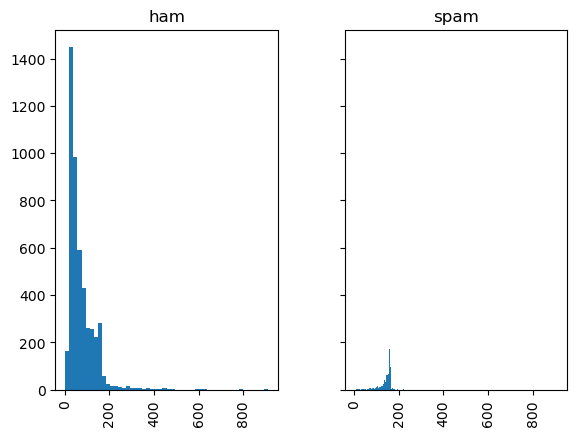

In [10]:
import matplotlib.pyplot as plt
data.hist(column='length',bins=50, by='Category', sharex=True, sharey=True)

In [12]:
!pip install nltk
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [18]:
import string
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import PorterStemmer
porter = PorterStemmer()

def clean_text(text):
    no_punc = [s for s in text if s not in string.punctuation]
    no_punc = ''.join(no_punc)
    rm_words = [porter.stem(w) for w in no_punc.split() if w.lower() not in stop_words]
    return ' '.join(rm_words)

In [19]:
data['train_text'] = data.Message.apply(clean_text)

In [20]:
data.head()

,Category,Message,length,train_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah dont think goe usf live around though


In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

bag_of_words = CountVectorizer()

bag_of_words.fit(data['train_text'])

CountVectorizer()

In [23]:
txt_transform = bag_of_words.transform(data.Message)
print(txt_transform.shape)

(5572, 8095)


# Using Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB
mn = MultinomialNB()
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(txt_transform,data.Category, test_size=0.3)
mn.fit(train_X ,train_y)
mn.score(test_X,test_y)

0.9778708133971292

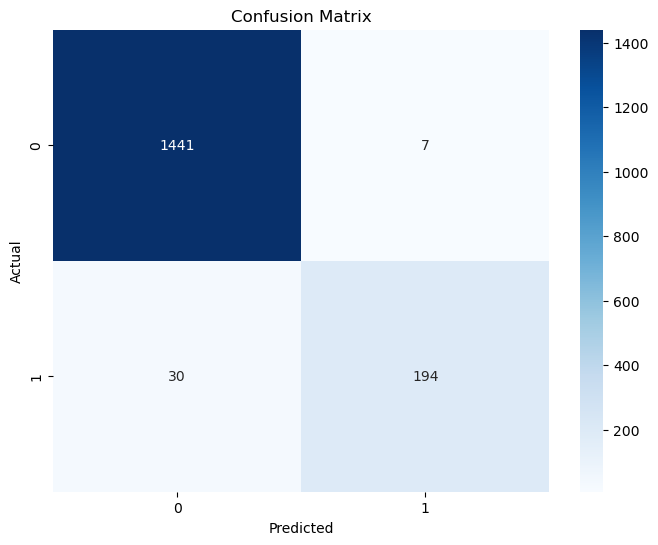

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       0.97      0.87      0.91       224

    accuracy                           0.98      1672
   macro avg       0.97      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
predictions = mn.predict(test_X)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_y, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_report = classification_report(test_y, predictions)
print("Classification Report:")
print(class_report)

# Using Bert


In [37]:
!pip install transformers


In [38]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

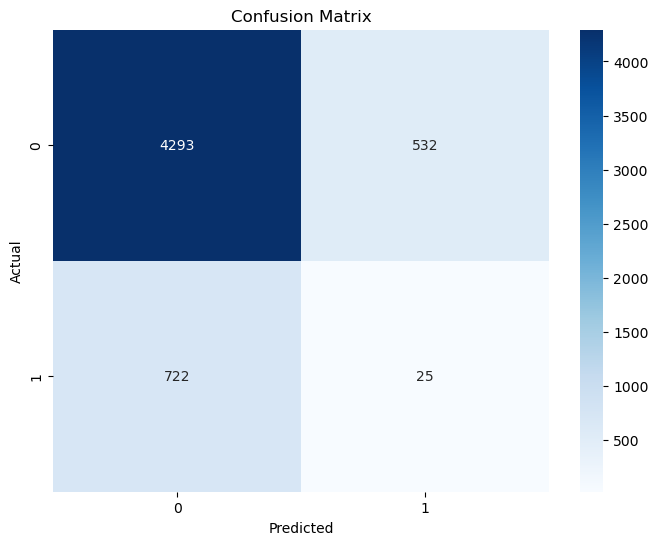

              precision    recall  f1-score   support

         ham       0.86      0.89      0.87      4825
        spam       0.04      0.03      0.04       747

    accuracy                           0.77      5572
   macro avg       0.45      0.46      0.46      5572
weighted avg       0.75      0.77      0.76      5572



In [39]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



# Prepare your text data
texts = data['Message'].tolist()
labels = data['Category'].tolist()

# Tokenize and encode the text data
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128, add_special_tokens=True)

# Perform inference
with torch.no_grad():
    logits = model(**inputs).logits

# Get the predicted classes (0 for ham, 1 for spam)
predicted_classes = torch.argmax(logits, dim=1).tolist()

# Define class labels
class_labels = ["ham", "spam"]

# Get the predicted labels
predicted_labels = [class_labels[p] for p in predicted_classes]

# Add the predicted labels to your DataFrame
data['Predicted_Category'] = predicted_labels

# Plot confusion matrix
cm = confusion_matrix(labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Calculate and print classification report with F1 scores
classification_rep = classification_report(labels, predicted_labels)
print(classification_rep)
